In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import curve_fit, least_squares, leastsq
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [3]:
oae = xr.open_dataset("c:\\Users\\junsu\\my_project\\data\\OAE_efficiency_maps_alltime.nc")

In [86]:
oae_df = oae.to_dataframe()
oae_df = oae_df.reset_index().pivot(
    index="N_month", columns=["nlat", "nlon", "season"], values="OAE_efficiency"
)
oae_df.index += 1
oae_df.dropna(axis=1, how="all", inplace=True)
oae_diffed = oae_df - oae_df.shift().fillna(0)

# Basic Analysis

## Time Series Plot

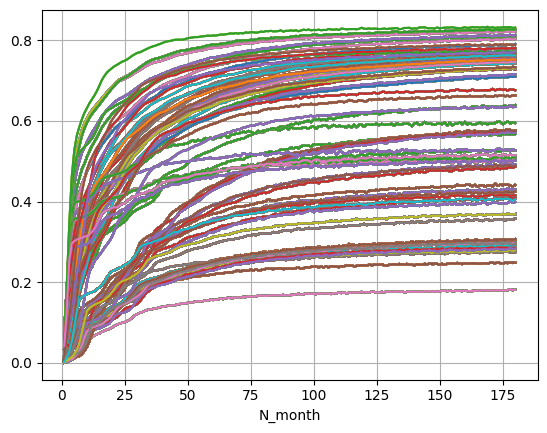

In [88]:
oae_df.iloc[:, :5000].plot(legend=False, grid=True)
plt.show()

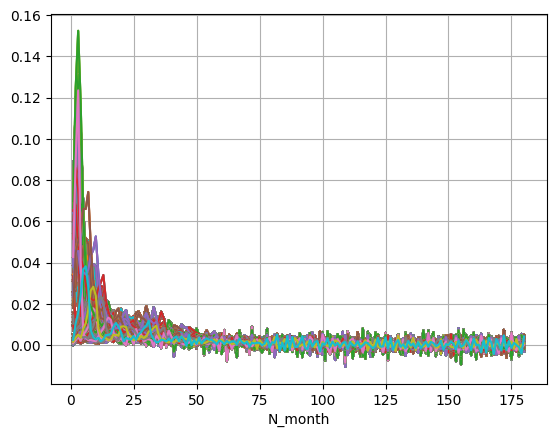

In [89]:
oae_diffed.iloc[:, :5000].plot(legend=False, grid=True)
plt.show()

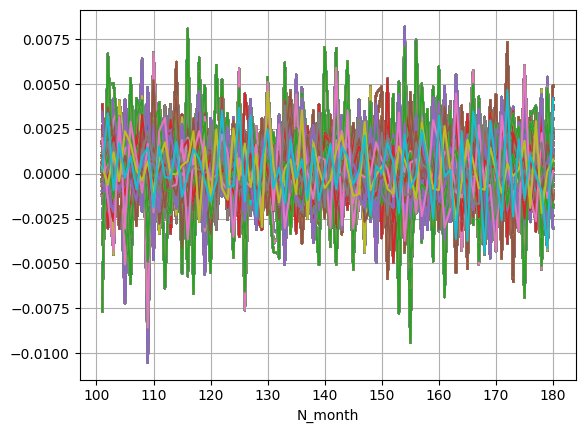

In [165]:
oae_diffed.iloc[100:, :5000].plot(legend=False, grid=True)
plt.show()

In [ ]:
oae_diffed.iloc[100:, :5000].hist(bins=100)
plt.show()

In [ ]:
oae_diffed.iloc[100:, :5000].flatten().hist(bins=100)

## Drift

N_month
1      0.028776
2      0.042606
3      0.052881
4      0.043742
5      0.036604
         ...   
176    0.000080
177    0.000256
178    0.000665
179    0.000088
180    0.000247
Length: 180, dtype: float64

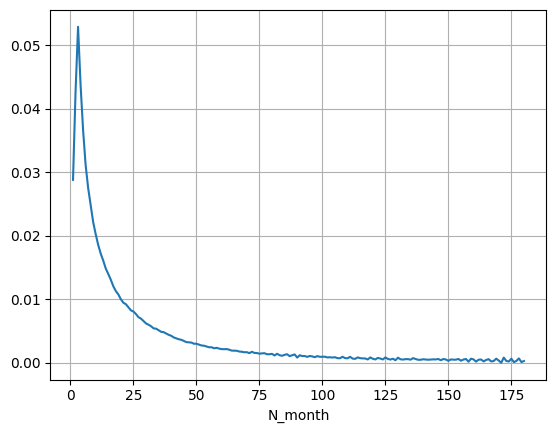

In [91]:
oae_diffed.mean(axis=1).plot(legend=False, grid=True)
oae_diffed.mean(axis=1)

## Relationship between Variables

### Seaonality

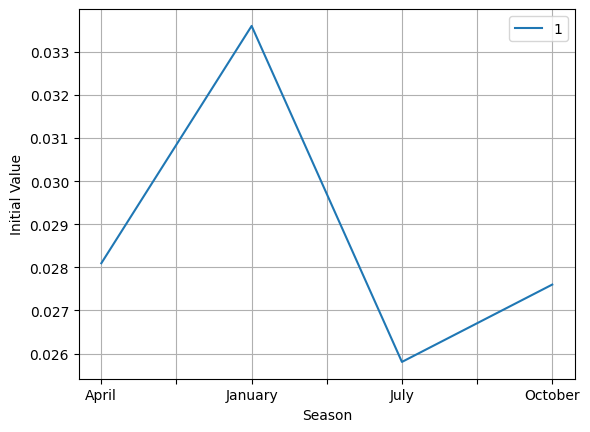

In [92]:
oae_df.iloc[0].groupby("season").mean().plot(legend=True, grid=True)
plt.xlabel("Season")
plt.ylabel("Initial Value")
plt.show()

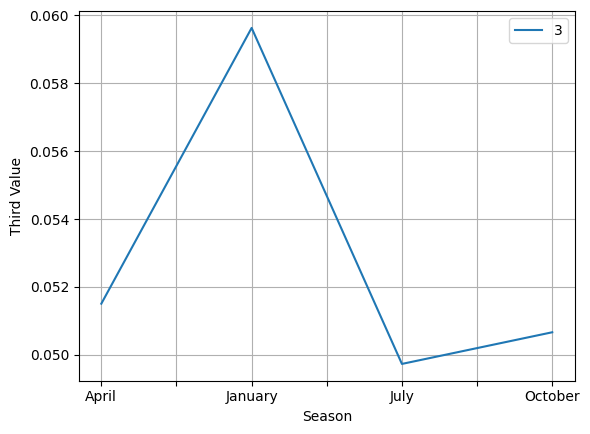

In [93]:
oae_diffed.iloc[2].groupby("season").mean().plot(legend=True, grid=True)
plt.xlabel("Season")
plt.ylabel("Third Value")
plt.show()

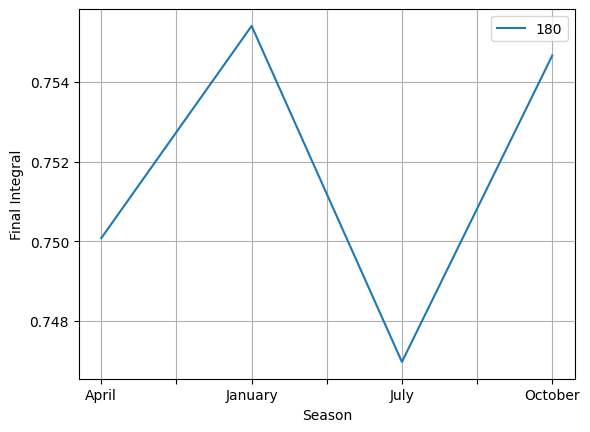

In [94]:
oae_df.iloc[-1].groupby("season").mean().plot(legend=True, grid=True)
plt.xlabel("Season")
plt.ylabel("Final Integral")
plt.show()

### Longitude

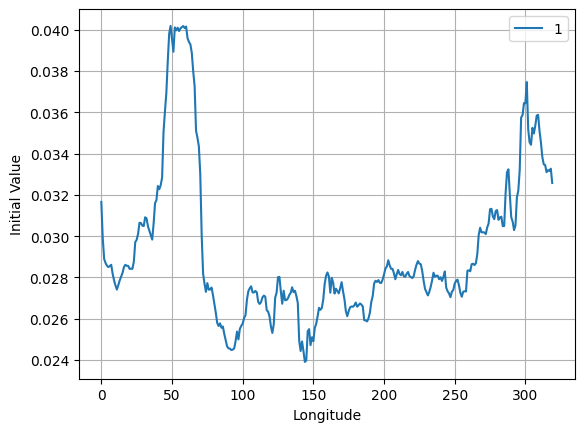

In [95]:
oae_df.iloc[0].groupby("nlon").mean().plot(legend=True, grid=True)
plt.xlabel("Longitude")
plt.ylabel("Initial Value")
plt.show()

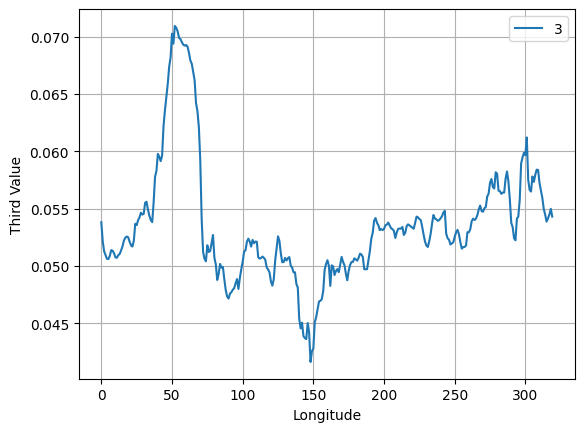

In [96]:
oae_diffed.iloc[2].groupby("nlon").mean().plot(legend=True, grid=True)
plt.xlabel("Longitude")
plt.ylabel("Third Value")
plt.show()

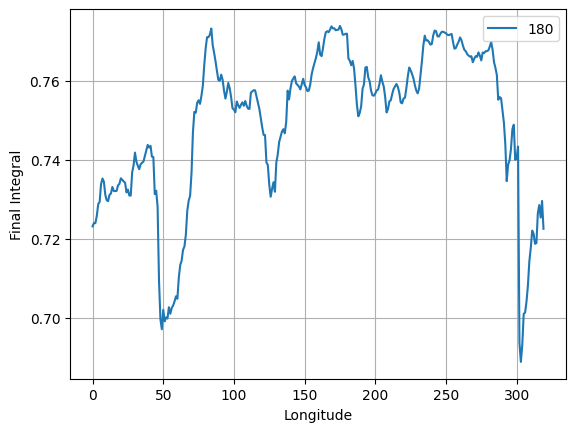

In [97]:
oae_df.iloc[-1].groupby("nlon").mean().plot(legend=True, grid=True)
plt.xlabel("Longitude")
plt.ylabel("Final Integral")
plt.show()

### Latitude

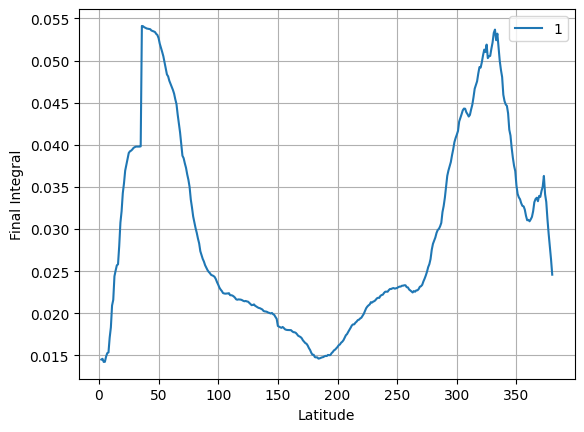

In [98]:
oae_df.iloc[0].groupby("nlat").mean().plot(legend=True, grid=True)
plt.xlabel("Latitude")
plt.ylabel("Final Integral")
plt.show()

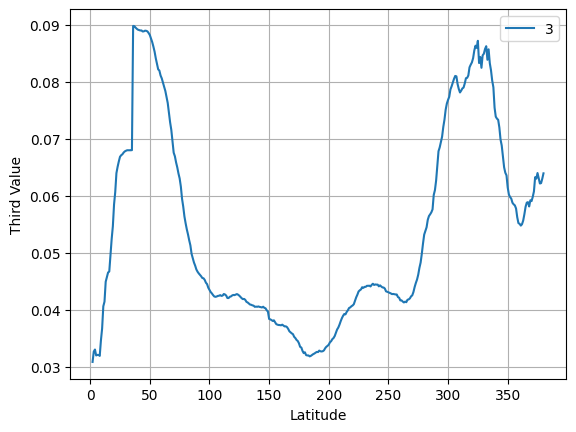

In [99]:
oae_diffed.iloc[2].groupby("nlat").mean().plot(legend=True, grid=True)
plt.xlabel("Latitude")
plt.ylabel("Third Value")
plt.show()

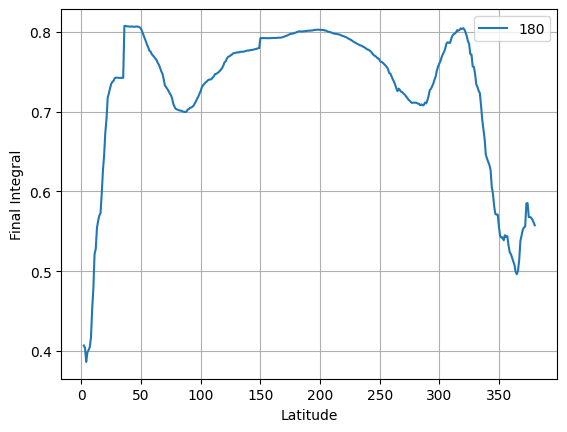

In [100]:
oae_df.iloc[-1].groupby("nlat").mean().plot(legend=True, grid=True)
plt.xlabel("Latitude")
plt.ylabel("Final Integral")
plt.show()

### Initial Value VS. Final Integral

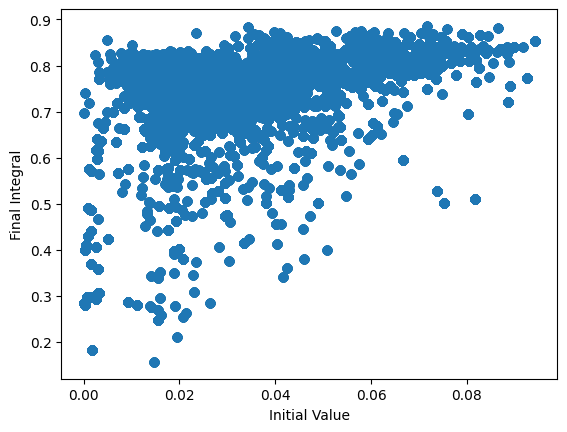

In [101]:
plt.scatter(oae_diffed.iloc[0], oae_df.iloc[-1])
plt.xlabel("Initial Value")
plt.ylabel("Final Integral")
plt.show()

### Third Value VS. Final Integral

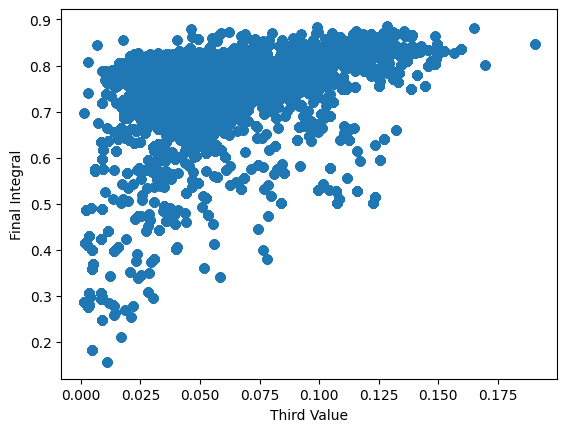

In [102]:
plt.scatter(oae_diffed.iloc[2], oae_df.iloc[-1])
plt.xlabel("Third Value")
plt.ylabel("Final Integral")
plt.show()

### Third Integral VS. Final Integral

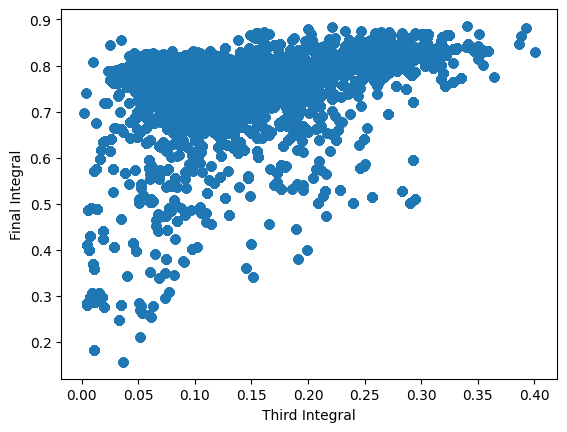

In [103]:
plt.scatter(oae_df.iloc[2], oae_df.iloc[-1])
plt.xlabel("Third Integral")
plt.ylabel("Final Integral")
plt.show()

# ANOVA

In [104]:
anova_df = (
    oae_diffed.iloc[[0, 2]]
    .transpose()
    .rename(columns={1: "initial_value", 3: "third_value"})
    .merge(
        oae_df.iloc[[2, -1]]
        .transpose()
        .rename(columns={3: "third_integral", 180: "final_integral"}),
        left_index=True,
        right_index=True,
    )
    .reset_index()
)

## Initial Value

In [105]:
model = ols("initial_value ~ nlat * nlon * C(season)", data=anova_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table["explained_variance (%)"] = anova_table["sum_sq"] / anova_table["sum_sq"].sum() * 100
display(anova_table)

,sum_sq,df,F,PR(>F),explained_variance (%)
C(season),2.670733,3.0,4243.596906,0.000000e+00,2.968627
nlat,2.716477,1.0,12948.844416,0.000000e+00,3.019474
nlat:C(season),18.080023,3.0,28727.819685,0.000000e+00,20.096677
nlon,0.063055,1.0,300.568802,2.661959e-67,0.070088
nlon:C(season),0.282509,3.0,448.886604,4.637959e-291,0.314021
nlat:nlon,0.000052,1.0,0.245682,6.201324e-01,0.000057
nlat:nlon:C(season),0.126242,3.0,200.588907,5.555723e-130,0.140323
Residual,66.026148,314732.0,NaN,NaN,73.390733


## Third Value

In [106]:
model = ols("third_value ~ nlat * nlon * C(season)", data=anova_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table["explained_variance (%)"] = anova_table["sum_sq"] / anova_table["sum_sq"].sum() * 100
display(anova_table)

,sum_sq,df,F,PR(>F),explained_variance (%)
C(season),4.907983,3.0,2953.463662,0.000000e+00,1.972919
nlat,4.717828,1.0,8517.104563,0.000000e+00,1.896480
nlat:C(season),64.501568,3.0,38814.937803,0.000000e+00,25.928445
nlon,0.090194,1.0,162.827178,2.787608e-37,0.036256
nlon:C(season),0.183489,3.0,110.417483,1.863668e-71,0.073759
nlat:nlon,0.015816,1.0,28.553376,9.121387e-08,0.006358
nlat:nlon:C(season),0.013131,3.0,7.901790,2.879170e-05,0.005278
Residual,174.337584,314732.0,NaN,NaN,70.080505


## Third Integral

In [107]:
model = ols("third_integral ~ nlat * nlon * C(season)", data=anova_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table["explained_variance (%)"] = anova_table["sum_sq"] / anova_table["sum_sq"].sum() * 100
display(anova_table)

,sum_sq,df,F,PR(>F),explained_variance (%)
C(season),33.271742,3.0,3532.125072,0.000000e+00,2.364661
nlat,37.383029,1.0,11905.736797,0.000000e+00,2.656855
nlat:C(season),344.416914,3.0,36563.267899,0.000000e+00,24.478109
nlon,0.912836,1.0,290.719773,3.707348e-65,0.064876
nlon:C(season),1.829221,3.0,194.189915,7.915515e-126,0.130005
nlat:nlon,0.255097,1.0,81.243248,2.006510e-19,0.018130
nlat:nlon:C(season),0.739250,3.0,78.478665,9.646815e-51,0.052539
Residual,988.232456,314732.0,NaN,NaN,70.234824


## Final Integral

In [108]:
model = ols("final_integral ~ nlat * nlon * C(season) * initial_value", data=anova_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table["explained_variance (%)"] = anova_table["sum_sq"] / anova_table["sum_sq"].sum() * 100
display(anova_table)

,sum_sq,df,F,PR(>F),explained_variance (%)
C(season),12.580537,3.0,818.438906,0.000000e+00,0.579925
nlat,3.131404,1.0,611.149497,8.469165e-135,0.144348
nlat:C(season),85.706951,3.0,5575.747765,0.000000e+00,3.950835
nlon,7.892668,1.0,1540.395146,0.000000e+00,0.363828
nlon:C(season),0.560734,3.0,36.479100,1.463818e-23,0.025848
nlat:nlon,81.909156,1.0,15986.035704,0.000000e+00,3.775768
nlat:nlon:C(season),15.813792,3.0,1028.781406,0.000000e+00,0.728969
initial_value,8.259751,1.0,1612.037945,0.000000e+00,0.380750
C(season):initial_value,46.362803,3.0,3016.176571,0.000000e+00,2.137187
nlat:initial_value,117.173307,1.0,22868.465149,0.000000e+00,5.401341


In [109]:
model = ols("final_integral ~ nlat * nlon * C(season) * third_value", data=anova_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table["explained_variance (%)"] = anova_table["sum_sq"] / anova_table["sum_sq"].sum() * 100
display(anova_table)

,sum_sq,df,F,PR(>F),explained_variance (%)
C(season),11.520362,3.0,784.522226,0.000000e+00,0.543910
nlat,0.310415,1.0,63.416565,1.678572e-15,0.014656
nlat:C(season),93.585016,3.0,6373.022680,0.000000e+00,4.418427
nlon,8.313911,1.0,1698.500903,0.000000e+00,0.392524
nlon:C(season),0.521739,3.0,35.529787,5.998959e-23,0.024633
nlat:nlon,59.937167,1.0,12244.938506,0.000000e+00,2.829812
nlat:nlon:C(season),12.471869,3.0,849.318682,0.000000e+00,0.588834
third_value,38.729545,1.0,7912.300954,0.000000e+00,1.828537
C(season):third_value,67.478871,3.0,4595.226818,0.000000e+00,3.185878
nlat:third_value,56.366835,1.0,11515.533202,0.000000e+00,2.661246


In [110]:
model = ols("final_integral ~ nlat * nlon * C(season) * third_integral", data=anova_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table["explained_variance (%)"] = anova_table["sum_sq"] / anova_table["sum_sq"].sum() * 100
display(anova_table)

,sum_sq,df,F,PR(>F),explained_variance (%)
C(season),14.190838,3.0,955.540841,0.000000e+00,0.664902
nlat,1.008761,1.0,203.774964,3.240017e-46,0.047265
nlat:C(season),84.600280,3.0,5696.564312,0.000000e+00,3.963889
nlon,8.595000,1.0,1736.234253,0.000000e+00,0.402713
nlon:C(season),0.503787,3.0,33.922522,6.529921e-22,0.023605
nlat:nlon,67.858266,1.0,13707.719778,0.000000e+00,3.179453
nlat:nlon:C(season),10.906113,3.0,734.363677,0.000000e+00,0.510999
third_integral,26.499299,1.0,5352.995036,0.000000e+00,1.241607
C(season):third_integral,53.587241,3.0,3608.299738,0.000000e+00,2.510794
nlat:third_integral,79.643040,1.0,16088.304895,0.000000e+00,3.731621


# Drift Estimation: Parametric Approach

## Normalization

0.4176326108676591


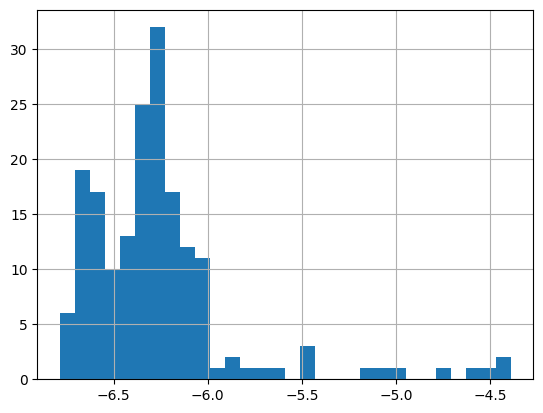

In [111]:
log_std = np.log(oae_diffed.diff().std(axis=1))
print(log_std.std())
log_std.hist(bins=30)
plt.show()

0.6455090408506023


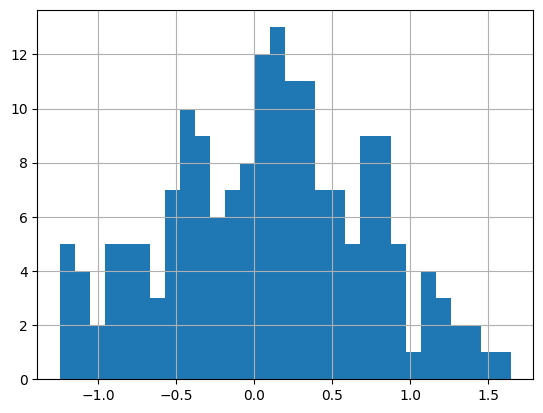

In [112]:
log_std = np.log(oae_diffed.div(oae_diffed.iloc[0]).diff().std(axis=1))
print(log_std.std())
log_std.hist(bins=30)
plt.show()

0.4509025029319559


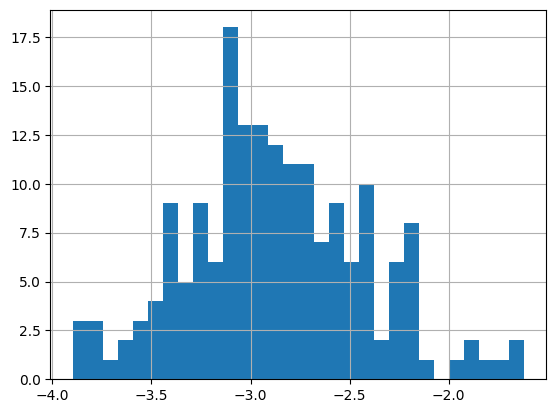

In [113]:
log_std = np.log(oae_diffed.div(oae_df.iloc[2]).diff().std(axis=1))
print(log_std.std())
log_std.hist(bins=30)
plt.show()

0.3761642181737877


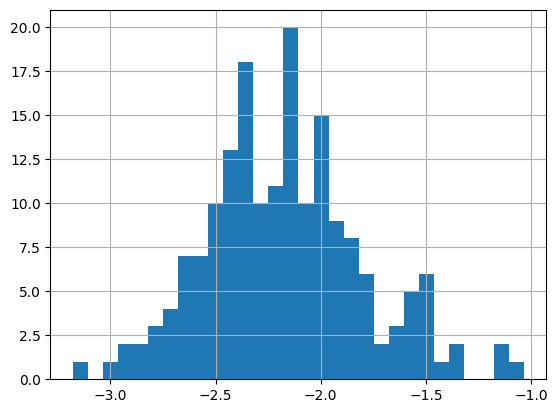

In [114]:
log_std = np.log(oae_diffed.div(oae_diffed.iloc[2]).diff().std(axis=1))
print(log_std.std())
log_std.hist(bins=30)
plt.show()

,sum_sq,df,F,PR(>F),explained_variance (%)
C(season),4.907983,3.0,2948.420617,0.0,1.973072
nlat,4.701177,1.0,8472.552567,0.0,1.889934
C(season):nlat,64.498837,3.0,38747.020839,0.0,25.929367
Residual,174.640213,314740.0,NaN,NaN,70.207626


0.3771646176840699


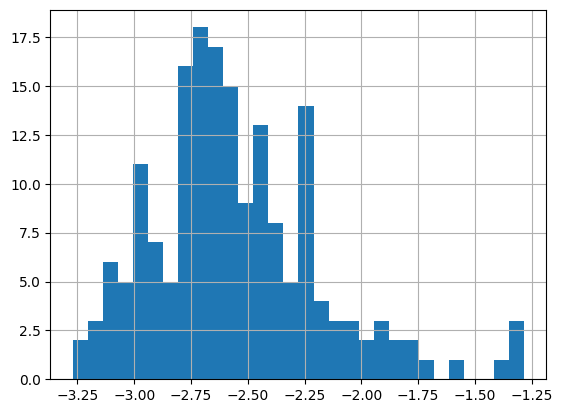

In [117]:
model = ols("third_value ~ C(season) + nlat + C(season):nlat", data=anova_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table["explained_variance (%)"] = anova_table["sum_sq"] / anova_table["sum_sq"].sum() * 100
display(anova_table)

log_std = np.log(oae_diffed.div(model.fittedvalues.to_numpy()).diff().std(axis=1))
print(log_std.std())
log_std.hist(bins=30)
plt.show()

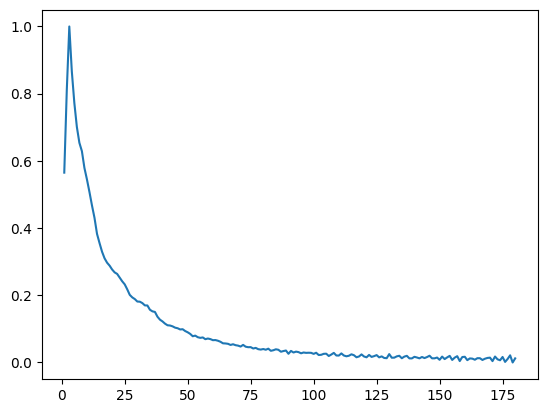

N_month
1      0.564424
2      0.810173
3      1.000000
4      0.865969
5      0.772101
         ...   
176    0.000496
177    0.009172
178    0.020092
179   -0.001241
180    0.010985
Length: 180, dtype: float64

In [118]:
# normalized_oae_diffed = oae_diffed.div(model.fittedvalues.to_numpy(), axis=1)
normalized_oae_diffed = oae_diffed.div(oae_diffed.iloc[2], axis=1)
drift = normalized_oae_diffed.mean(axis=1).dropna()
plt.plot(drift)
plt.show()
drift

In [129]:
truncated_drift = drift.iloc[2:]
log_truncated_drift = np.log(truncated_drift).dropna()

c:\Users\junsu\my_project\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Log Transformation

### Exponential Decay

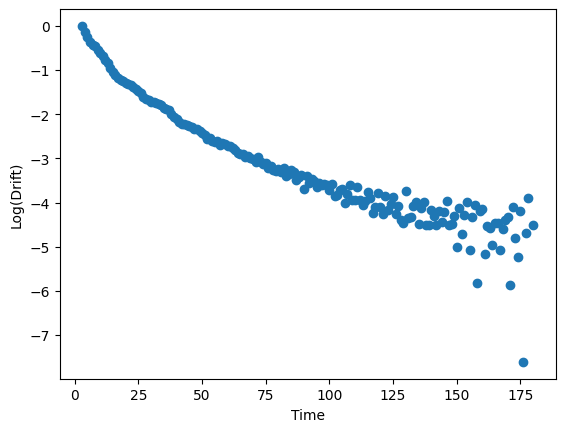

In [123]:
plt.scatter(log_truncated_drift.index, log_truncated_drift)
plt.xlabel("Time")
plt.ylabel("Log(Drift)")
plt.show()

In [124]:
model = sm.OLS(log_truncated_drift, sm.add_constant(log_truncated_drift.index))
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     1448.
Date:                Thu, 08 May 2025   Prob (F-statistic):           1.49e-86
Time:                        17:32:34   Log-Likelihood:                -100.60
No. Observations:                 177   AIC:                             205.2
Df Residuals:                     175   BIC:                             211.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0170      0.066    -15.421      0.0

### Power Law

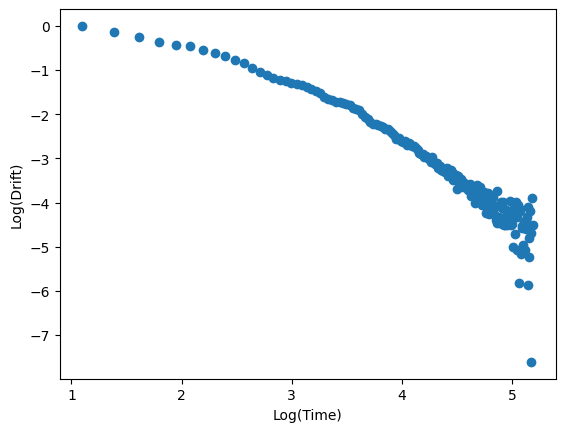

In [125]:
plt.scatter(np.log(log_truncated_drift.index), log_truncated_drift)
plt.xlabel("Log(Time)")
plt.ylabel("Log(Drift)")
plt.show()

In [126]:
model = sm.OLS(log_truncated_drift, sm.add_constant(log_truncated_drift.index))
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     1448.
Date:                Thu, 08 May 2025   Prob (F-statistic):           1.49e-86
Time:                        17:32:53   Log-Likelihood:                -100.60
No. Observations:                 177   AIC:                             205.2
Df Residuals:                     175   BIC:                             211.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0170      0.066    -15.421      0.0

### Shifted Power law

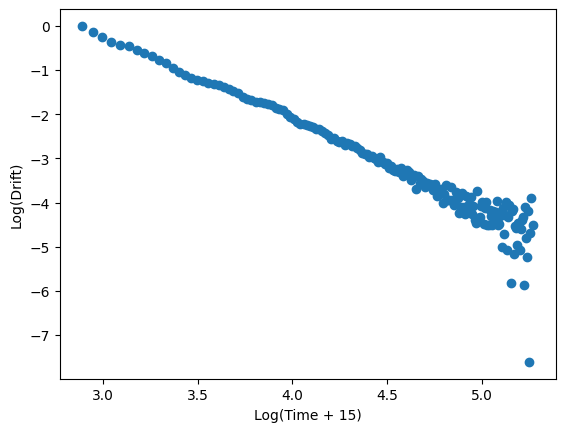

In [127]:
plt.scatter(np.log(log_truncated_drift.index + 15), log_truncated_drift)
plt.xlabel("Log(Time + 15)")
plt.ylabel("Log(Drift)")
plt.show()

In [128]:
model = sm.OLS(log_truncated_drift, sm.add_constant(np.log(log_truncated_drift.index + 15)))
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     2745.
Date:                Thu, 08 May 2025   Prob (F-statistic):          6.94e-109
Time:                        17:33:13   Log-Likelihood:                -48.620
No. Observations:                 177   AIC:                             101.2
Df Residuals:                     175   BIC:                             107.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.1445      0.180     34.122      0.0

## Estimating the Optiaml Shift

t0:  14.014964023590943 beta:  -1.8510864392682753


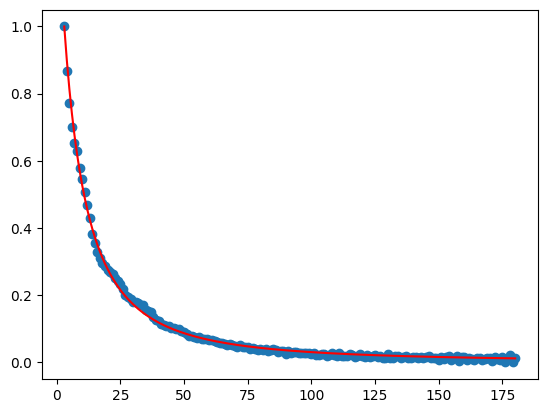

R-squared:  0.9972105006108909


In [133]:
# shifted power law model
def shifted_powerlaw(t, t0, beta):
    return ((t + t0) / (3 + t0)) ** beta


# Initial guess
# drift = exp(6.2101 -2.1615 * log(t + 15)) = exp(6.2101) * (t + 15)**(-2.1615)
p0 = [15.0, -2.1615]

# Fit the model
params, cov = curve_fit(
    shifted_powerlaw,
    truncated_drift.index,
    truncated_drift,
    p0=p0,
    bounds=([0, -10], [100, 0]),
)
print("t0: ", params[0], "beta: ", params[1])

plt.scatter(truncated_drift.index, truncated_drift)
plt.plot(truncated_drift.index, shifted_powerlaw(truncated_drift.index, *params), color="red")
plt.show()

print(
    "R-squared: ",
    1
    - np.sum((truncated_drift - shifted_powerlaw(truncated_drift.index, *params)) ** 2)
    / np.sum((truncated_drift - truncated_drift.mean()) ** 2),
)

# Stochastic Process

## Ornstein-Uhlenbeck Process

Intuitively, we should use a stochastic process that tends to zero and depends on the previous state to model the $\Delta \text{CO}_2$.
The Ornstein-Uhlenbeck process whcih is a continuous counterpart to AR(1) process is the simplest process that satisfies such properties:
$$\mathrm{d}X_t = -\kappa X_t \mathrm{d}t + \sigma \mathrm{d}W_t.$$
This SDE has a closed-form solution and its transition density is Gaussian.

## Extension to OU Process

One of natural extensions to this process can be formulated as follows:
$$\mathrm{d}X_t = -f(t) X_t \mathrm{d}t + g(t) \mathrm{d}W_t$$
where $f(t), g(t) > 0$.

### Solution

The solution to this SDE is calculated as follows:
$$
    X_t = e^{-F(t)}X_0 + e^{-F(t)}\int_0^t g(u) e^{F(u)} \mathrm{d}W_u
$$
where $F(t) = \int_0^t f(u) \mathrm{d}u$.

Its conditional expectation and variance are calculated as follows:
$$
    \begin{align*}
        \mathbb{E} \left[ X_t \vert X_0\right] &= e^{-F(t)}X_0\\
        \operatorname{Var} \left[ X_t \vert X_0\right] &= \mathbb{E} \left[ \left. \left( e^{-F(t)}\int_0^t g(u) e^{F(u)} \mathrm{d}W_u \right)^2 \right\vert X_0\right]\\
        &= \int_0^t g^2(u) e^{2(F(u) - F(t))} \mathrm{d}u  \because \text{ It\^o isometry}
    \end{align*}
$$

#### Derivation

$$
    \begin{align*}
        g(t) e^{F(t)} \mathrm{d}W_t &= e^{F(t)} \mathrm{d}X_t + f(t) e^{F(t)} X_t \mathrm{d}t\\
        &= \mathrm{d} \left(e^{F(t)} X_t \right).
    \end{align*}
$$
Therefore,
$$
    e^{F(t)} X_t  = X_0 + \int_0^t g(u) e^{F(u)} \mathrm{d}W_u
$$

### Our Case

The drift should look like a shifted power law. Therefore,
$$
    e^{-F(t)} = \exp\left(\alpha + \beta \log\left(t + t_0\right) \right).
$$
$$
\Rightarrow F(t) = -\alpha - \beta \log\left(t + t_0\right) \text{ and } f(t) = - \frac{\beta}{t + t_0}
$$

This implies that the speed of mean reversion gets slower as time elapses.

### Diffusion Term

From the data, we can parametrize $h(t) = \operatorname{Var} \left[ X_t \vert X_0\right]$.

Since $$h(t) = \int_0^t g^2(u) e^{2(F(u) - F(t))} \mathrm{d}u,$$
we get
$$
\begin{align*}
    h^{\prime}(t) &= g^2(t) e^{2(F(t) - F(t))} - 2f(t) \int_0^t g^2(u) e^{2(F(u) - F(t))} \mathrm{d}u\\
\end{align*}
$$

# Diffusion Estimation: Parametric Approach

In [152]:
t = np.arange(4, 180)
((t + params[0]) / (t - 1 + params[0]))**params[1]

array([0.89968127, 0.90483545, 0.90948617, 0.91370373, 0.91754592,
       0.92106069, 0.92428818, 0.9272622 , 0.93001149, 0.93256057,
       0.93493055, 0.93713965, 0.93920371, 0.94113656, 0.94295033,
       0.94465568, 0.94626205, 0.94777782, 0.94921044, 0.95056657,
       0.95185217, 0.95307261, 0.95423271, 0.95533685, 0.95638898,
       0.95739268, 0.95835122, 0.95926759, 0.96014451, 0.96098446,
       0.96178975, 0.96256247, 0.96330456, 0.9640178 , 0.96470385,
       0.96536423, 0.96600035, 0.96661353, 0.96720499, 0.96777586,
       0.96832719, 0.96885998, 0.96937513, 0.96987353, 0.97035596,
       0.97082318, 0.97127591, 0.9717148 , 0.97214048, 0.97255354,
       0.97295453, 0.97334398, 0.97372236, 0.97409016, 0.9744478 ,
       0.97479571, 0.97513426, 0.97546385, 0.97578481, 0.97609748,
       0.97640218, 0.97669921, 0.97698886, 0.97727139, 0.97754707,
       0.97781615, 0.97807885, 0.9783354 , 0.97858601, 0.9788309 ,
       0.97907025, 0.97930424, 0.97953306, 0.97975688, 0.97997

In [161]:
t = np.arange(4, 181)
resid = normalized_oae_diffed.iloc[3:] - normalized_oae_diffed.iloc[2:-1].mul(((t + params[0]) / (t - 1 + params[0]))**params[1], axis=0).values

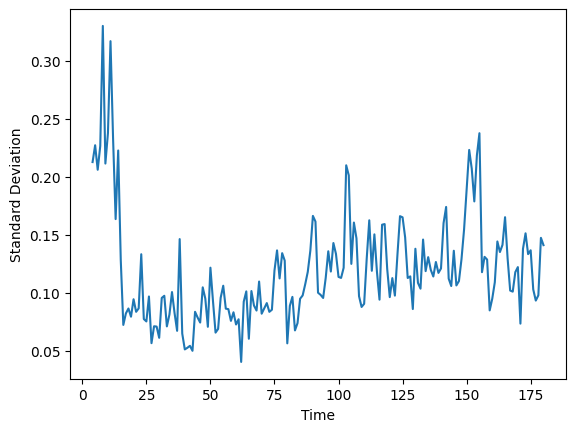

In [164]:
resid.std(axis=1).plot()
plt.xlabel("Time")
plt.ylabel("Standard Deviation")
plt.show()